# Example - ML model of Hirshfeld ratios
- Tristan Bereau (Max Planck Institute for Polymer Research, Mainz, Germany, `bereau@mpip-mainz.mpg.de`)

To be used together with the IPML software
`https://gitlab.mpcdf.mpg.de/trisb/ipml`

See also
```
Tristan Bereau, Robert A. DiStasio Jr., Alexandre Tkatchenko, 
and O. Anatole von Lilienfeld, Non-covalent interactions across organic and 
biological subsets of chemical space: Physics-based potentials parametrized 
from machine learning, J Chem Phys (in press); see also https://arxiv.org/abs/1710.05871
```

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import pickle
import glob
import os
import numpy as np
import scipy.stats
import random
import logging
np.set_printoptions(precision=3, suppress=True)

In [4]:
import ipml
from ipml.calculator import Calculator
from ipml.system import System
from ipml.hirshfeld import Hirshfeld

## Load training data of Hirshfeld ratios

In [5]:
def split_data(ref_sims, fraction=0.75, seed=1):
    # Split data into training and test
    # Returns training and test sets
    random.seed(seed)
    random.shuffle(ref_sims)
    train_frac = int(len(ref_sims)*fraction)
    return ref_sims[:train_frac], ref_sims[train_frac:]

In [66]:
# Path to xyz and horton files for PBE0 valence widths
path_to_refs = ["hirshfeld_database"]
refs = []
count =0
for p in path_to_refs:
    for xyz in glob.glob(p + "/*.xyz")[:1000]:
        if os.stat(xyz).st_size > 0:
            refs.append(xyz)

In [67]:
def train_and_predict(train, test):
    # Initialize
    calc = Calculator()
    hirsh = Hirshfeld(calc)
    for xyz in train:
        mol1 = System(xyz=xyz)
        hirsh.add_mol_to_training(mol1)
    # Train
    hirsh.train_ml("krr")
    # Predict
    hirsh_pred, hirsh_ref, ele_ref = np.array([]), np.array([]), np.array([])
    for xyz in test:
        mol = System(xyz=xyz)
        hirsh_ref  = np.append(hirsh_ref, mol.hirshfeld_ref)
        hirsh.predict_mol(mol, "krr")
        ele_ref = np.append(ele_ref, mol.elements)
        hirsh_pred = np.append(hirsh_pred, mol.hirshfeld_ratios)
    return hirsh_pred,hirsh_ref,ele_ref,hirsh

## Train and predict ML model for different training set sizes

In [68]:
hirsh_pred = []
hirsh_ref  = []
hirsh   = []
ele_ref= []
frac   = [0.01,0.02,0.05,0.1,0.2,0.3,0.5,0.6,0.8]
train_size = []
for f in frac:
    train, test = split_data(refs, fraction=f)
    print "Training/test sizes:", len(train), len(test)
    train_count = 0
    for xyz in train:
        mol = System(xyz)
        train_count += mol.num_atoms
    train_size.append(train_count)
    hirsh_pred_i, hirsh_ref_i, ele_ref_i, hirsh_i = train_and_predict(train, test)
    hirsh_pred.append(hirsh_pred_i)
    hirsh_ref.append(hirsh_ref_i)
    ele_ref.append(ele_ref_i)
    hirsh.append(hirsh_i)

Training/test sizes: 10 990
Training/test sizes: 20 980
Training/test sizes: 50 950
Training/test sizes: 100 900
Training/test sizes: 200 800
Training/test sizes: 300 700
Training/test sizes: 500 500
Training/test sizes: 600 400
Training/test sizes: 800 200


## Plot saturation (error) curve

15417 15417


[]

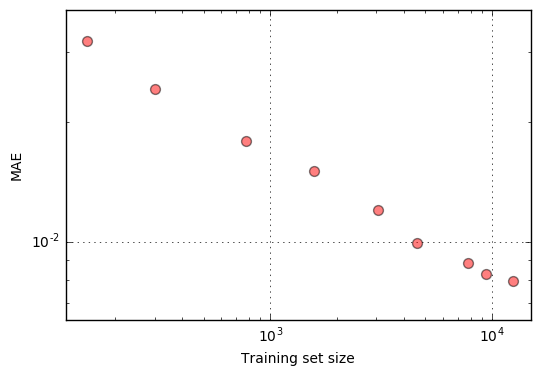

In [70]:
# Plot saturation curve
print len(hirsh_pred[0]), len(hirsh_ref[0])
maes = [np.mean(abs(hirsh_pred[i]-hirsh_ref[i])) for i in xrange(len(hirsh_pred))]
fig, ax = plt.subplots()
ax.scatter(train_size, maes, s=50, c='r', cmap=plt.cm.coolwarm, alpha=0.5, zorder=10)
ax.set_ylim([min(maes)*0.8,max(maes)*1.2])
ax.set_xlim([train_size[0]*0.8,train_size[-1]*1.2])
ax.loglog()
ax.grid()
ax.set_xlabel("Training set size")
ax.set_ylabel("MAE")
plt.plot()

## Output to text files

In [74]:
zip(train_size, maes)

[(149, 0.031836708314329505),
 (302, 0.024226417718302699),
 (774, 0.017876610942048222),
 (1579, 0.015046281744220588),
 (3052, 0.011996017795666045),
 (4592, 0.0099066355579471091),
 (7749, 0.0088111393451707903),
 (9376, 0.0082762061862945314),
 (12435, 0.0079397799389306963)]

In [76]:
np.savetxt('saturation.dat', np.array([train_size, maes]).T, 
           delimiter=" ", fmt="%s",
           header="Traing_size MAE")

In [80]:
zip(hirsh_pred[-1],hirsh_ref[-1],ele_ref[-1])

[(0.87839449475989317, 0.89258400000000004, 'N'),
 (0.86925563400318528, 0.87642160000000002, 'C'),
 (0.86866700840043676, 0.84603530000000005, 'C'),
 (0.84578987832381225, 0.83904860000000003, 'C'),
 (0.84137918677071211, 0.84323709999999996, 'C'),
 (0.85718134705408267, 0.85585789999999995, 'C'),
 (0.96213613089721095, 0.95926460000000002, 'N'),
 (0.67334619005297724, 0.66383099999999995, 'H'),
 (0.7084622092224907, 0.74877280000000002, 'H'),
 (0.70961278493473723, 0.68218440000000002, 'H'),
 (0.67637399133599618, 0.65678599999999998, 'H'),
 (0.67279772533678628, 0.67010729999999996, 'H'),
 (0.67326438691761559, 0.68866320000000003, 'H'),
 (0.97725130300384078, 0.97689749999999997, 'O'),
 (0.87136251183179747, 0.85708269999999998, 'C'),
 (0.86803053481707959, 0.8672221, 'C'),
 (0.8638656464688711, 0.832924, 'C'),
 (0.84250309765539555, 0.83957420000000005, 'C'),
 (0.82206927108651562, 0.81028120000000003, 'C'),
 (0.81966164523102192, 0.81364349999999996, 'C'),
 (0.64308811852537806, 

In [81]:
np.savetxt('correlation.dat', np.array([hirsh_pred[-1],hirsh_ref[-1],ele_ref[-1]]).T, 
           delimiter=" ", fmt="%s",
           header="Prediction Reference Atom")